In [9]:
from sentence_transformers import SentenceTransformer
import chromadb

# Setup
model = SentenceTransformer("all-MiniLM-L6-v2")
client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection(name="arxiv-papers")

# Example query
query = "Transformer-based methods for NER"
query_embedding = model.encode(query).tolist()

# Search top-5
results = collection.query(query_embeddings=[query_embedding], n_results=5)

for doc in results['documents'][0]:
    print(print(doc))  # Adjust based on your metadata schema


Characterizing the Expressivity of Transformer Language Models Transformer-based language models (LMs) have achieved widespread empirical success, but their theoretical expressive power remains only partially understood. Prior work often relies on idealized models with assumptions -- such as arbitrary numerical precision and hard attention -- that diverge from real-world transformers. In this work, we provide an exact characterization of fixed-precision transformers with strict future masking and soft attention, an idealization that more closely mirrors practical implementations. We show that these models are precisely as expressive as a specific fragment of linear temporal logic that includes only a single temporal operator: the past operator. We further relate this logic to established classes in formal language theory, automata theory, and algebra, yielding a rich and unified theoretical framework for understanding transformer expressivity. Finally, we present empirical results that

In [10]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Load all embeddings & metadata
results = collection.get(include=["embeddings", "metadatas", "documents"])
embeddings = np.array(results["embeddings"])
metadata = results["metadatas"]
title_abstract = results['documents'][0]

print(title_abstract)

# Cluster
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)

# Append cluster labels
df = pd.DataFrame(metadata)
df['cluster'] = kmeans.labels_

# Preview clustered papers
for i in range(k):
    print(f"\nCluster {i}")
    print(df[df.cluster == i]['published'].head(5).tolist())


Open CaptchaWorld: A Comprehensive Web-based Platform for Testing and   Benchmarking Multimodal LLM Agents CAPTCHAs have been a critical bottleneck for deploying web agents in real-world applications, often blocking them from completing end-to-end automation tasks. While modern multimodal LLM agents have demonstrated impressive performance in static perception tasks, their ability to handle interactive, multi-step reasoning challenges like CAPTCHAs is largely untested. To address this gap, we introduce Open CaptchaWorld, the first web-based benchmark and platform specifically designed to evaluate the visual reasoning and interaction capabilities of MLLM-powered agents through diverse and dynamic CAPTCHA puzzles. Our benchmark spans 20 modern CAPTCHA types, totaling 225 CAPTCHAs, annotated with a new metric we propose: CAPTCHA Reasoning Depth, which quantifies the number of cognitive and motor steps required to solve each puzzle. Experimental results show that humans consistently achiev

In [11]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import chromadb

# Load ChromaDB
client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection(name="arxiv-papers-v2")

# Load embeddings and documents
results = collection.get(include=["embeddings", "documents", "metadatas"])
embeddings = np.array(results["embeddings"])
documents = results["documents"]

# Try to extract the title (assumed to be the first line or first sentence)
def extract_title(doc):
    return doc.split('.')[0][:80]  # You can improve this by regex if needed

titles = [extract_title(doc) for doc in documents]

# Reduce dimensions using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)

# # Annotate a few random papers
# for i in np.random.choice(len(titles), 15, replace=False):
#     plt.text(embedding_2d[i, 0], embedding_2d[i, 1], titles[i] + "...", fontsize=8)

plt.title("UMAP Projection of ArXiv Paper Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(False)
plt.tight_layout()
plt.savefig('v2-umap.png')
plt.show()

InternalError: Error executing plan: Internal error: Error finding id

In [12]:
import hdbscan  # or use sklearn.cluster.KMeans as fallback

# Cluster the 2D UMAP embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
labels = clusterer.fit_predict(embedding_2d)

# Number of clusters found (excluding noise, which is -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters (plus noise)")


Found 74 clusters (plus noise)


/home/intern/miniconda3/envs/ai-research-assistant/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/intern/miniconda3/envs/ai-research-assistant/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



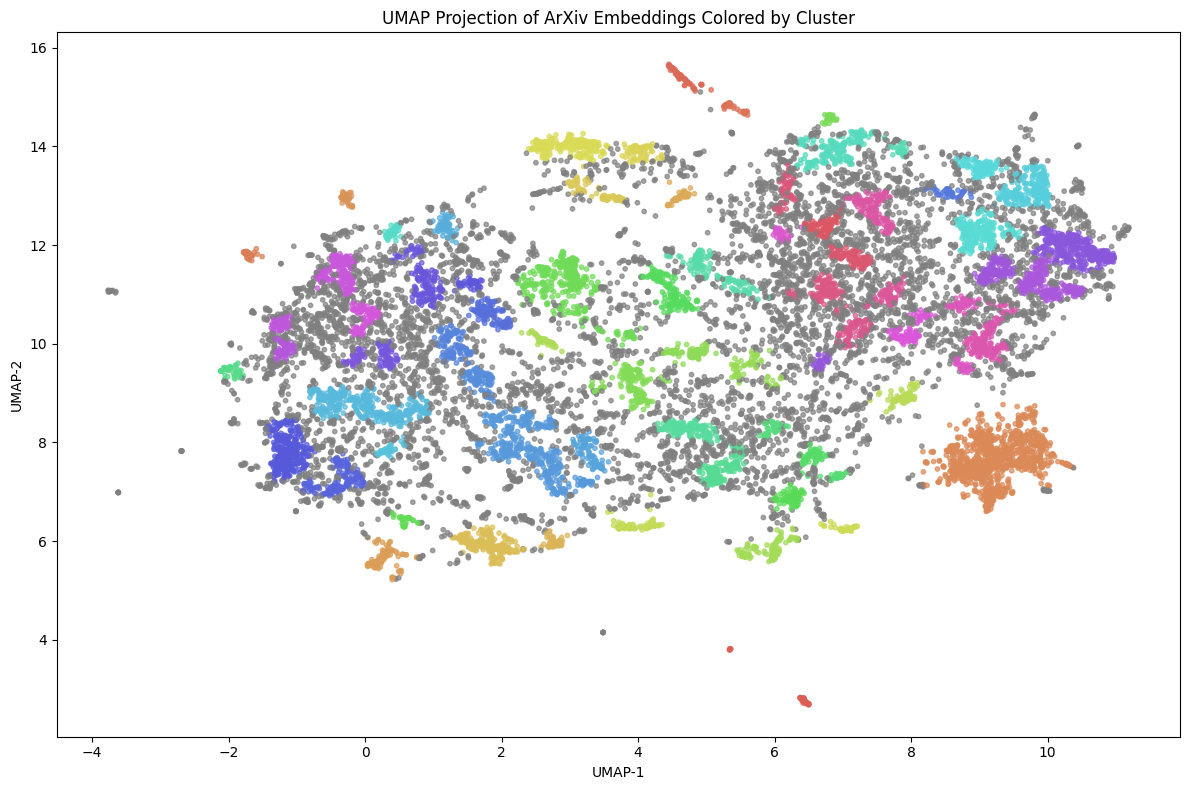

In [13]:
import seaborn as sns

# Create color palette
palette = sns.color_palette("hls", n_clusters + 1)

# Assign colors (-1 for noise, others for clusters)
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, s=10, alpha=0.7)

plt.title("UMAP Projection of ArXiv Embeddings Colored by Cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [14]:
from collections import defaultdict

cluster_map = defaultdict(list)

# Group titles by cluster label
for title, label in zip(titles, labels):
    cluster_map[label].append(title)

# Sort clusters by number of papers (descending), excluding noise (-1)
sorted_clusters = sorted(
    [(cluster_id, titles) for cluster_id, titles in cluster_map.items() if cluster_id != -1],
    key=lambda x: len(x[1]),
    reverse=True
)

# Display top 5 titles from each sorted cluster
for cluster_id, cluster_titles in sorted_clusters:
    print(f"\n🔹 Cluster {cluster_id} ({len(cluster_titles)} papers):")
    for title in cluster_titles[:5]:
        print(f"  - {title}")



🔹 Cluster 4 (985 papers):
  - Interpretable phenotyping of Heart Failure patients with Dutch discharge   lette
  - Automated Structured Radiology Report Generation Automated radiology report gene
  - TCM-Ladder: A Benchmark for Multimodal Question Answering on Traditional   Chine
  - Look & Mark: Leveraging Radiologist Eye Fixations and Bounding boxes in   Multim
  - Lunguage: A Benchmark for Structured and Sequential Chest X-ray   Interpretation

🔹 Cluster 43 (422 papers):
  - Chameleon: A Flexible Data-mixing Framework for Language Model   Pretraining and
  - How much do language models memorize? We propose a new method for estimating how
  - A Simple Linear Patch Revives Layer-Pruned Large Language Models Layer pruning h
  - Decoding Knowledge Attribution in Mixture-of-Experts: A Framework of   Basic-Ref
  - Domain Pre-training Impact on Representations This empirical study analyzes the 

🔹 Cluster 40 (372 papers):
  - CoRet: Improved Retriever for Code Editing In this paper, we in

In [15]:
import pandas as pd

data = []

for i, label in enumerate(labels):
    data.append({
        "Cluster": int(label),
        "Title": titles[i],
        "Summary": results["documents"][i],
        "Published": results["metadatas"][i].get("published", ""),
        "ID": results["ids"][i]
    })

df = pd.DataFrame(data)
df = df[df["Cluster"] != -1]  # optional: remove noise
df.sort_values(by="Cluster", inplace=True)
df.to_csv("clustered_arxiv_papers_v2.csv", index=False)

print("Saved clustered data to clustered_arxiv_papers.csv")


IndexError: list index out of range

In [16]:
import plotly.express as px

df_viz = pd.DataFrame({
    "x": embedding_2d[:, 0],
    "y": embedding_2d[:, 1],
    "Cluster": labels,
    "Title": titles
})

# Optional: remove noise
df_viz = df_viz[df_viz["Cluster"] != -1]

fig = px.scatter(
    df_viz,
    x="x",
    y="y",
    color=df_viz["Cluster"].astype(str),
    hover_data=["Title"],
    title="UMAP Projection of ArXiv Papers by Cluster"
)

fig.show()
